In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Project 3A

/content/drive/MyDrive/Colab Notebooks/Project 3A


In [13]:
!pip install pymodis -q

     |████████████████████████████████| 3.0 MB 4.0 MB/s 


In [ ]:
def image_crop(img_path,dir,step,size):
  # INPUT:
  # img_path = input image path to be cropped | or hdf file path ("/a/b/c.hdf")
  # dir = directory for saving cropped images
  # step, size: parameters of "sliding_window()"

  # OUTPUT: images cropped from the image in img_path, saved to dir

  if Path(img_path).suffix == ".hdf":
    img_day, img_night = read_modis(img_path)
    if img_day is None or img_night is None:
      print("Cannot handle this MODIS file: ", img_path, ". Please check it again")
    else:
      # For day image
      win_count = 0
      for (x,y,window) in sliding_window(img_day, step, size):
        if window.shape[0] != size[0] or window.shape[1] != size[1]:
          continue
        # img_cropped_name = os.path.split(img_path)[1].split(".")[0] + "_%d"%win_count + ".png"
        img_cropped_name = Path(img_path).stem + ".day.%d"%win_count
        save_path = os.path.join(dir,img_cropped_name)
        # save_path = dir + "/" + img_cropped_name
        img_cropped = window
        # io.imsave(save_path,img_cropped)
        np.save(save_path,img_cropped)
        win_count += 1
      print("Number of cropped day images", win_count)

      # For night image
      win_count = 0
      for (x,y,window) in sliding_window(img_night, step, size):
        if window.shape[0] != size[0] or window.shape[1] != size[1]:
          continue
        # img_cropped_name = os.path.split(img_path)[1].split(".")[0] + "_%d"%win_count + ".png"
        img_cropped_name = Path(img_path).stem + ".night.%d"%win_count
        save_path = os.path.join(dir,img_cropped_name)
        # save_path = dir + "/" + img_cropped_name
        img_cropped = window
        # io.imsave(save_path,img_cropped)
        np.save(save_path,img_cropped)
        win_count += 1
      print("Number of cropped night images", win_count)

  else:
    img = io.imread(img_path)
    if img is None:
      print("This is not an image")
    else:
      win_count = 0
      for (x,y,window) in sliding_window(img, step, size):
        if window.shape[0] != size[0] or window.shape[1] != size[1]:
          continue
        # img_cropped_name = os.path.split(img_path)[1].split(".")[0] + "_%d"%win_count + ".png"
        img_cropped_name = Path(img_path).stem + ".%d"%win_count + ".png"
        save_path = os.path.join(dir,img_cropped_name)
        # save_path = dir + "/" + img_cropped_name
        img_cropped = window
        io.imsave(save_path,img_cropped)
        win_count += 1
      print("Number of cropped images", win_count)

In [3]:
import torch.nn as nn
import torch.nn.functional as F
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=2, padding_mode='replicate')
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2, padding_mode='replicate')
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [4]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import h5py
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [6]:
# learning parameters
batch_size = 8 # batch size, reduce if facing OOM error
epochs = 100 # number of epochs to train the SRCNN model for
lr = 0.001 # the learning rate
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
# input image dimensions
img_rows, img_cols = 64, 64
out_rows, out_cols = 64, 64

In [8]:
# # Read input
# input_train_path = "dataset/low_res/train/"
# input_test_path = "dataset/low_res/test/"

# output_train_path = "dataset/high_res/train/"
# output_test_path = "dataset/high_res/test/"
data_path = 'dataset/tifs_files/1km/'


In [9]:
from glob import glob
# train_files = glob(input_train_path + "*npy")
# test_files = glob(input_test_path + "*npy")

# train_labels = glob(output_train_path + "*npy")
# test_labels = glob(output_test_path + "*npy")
files = glob(data_path + "*.tif")

In [14]:
def read_tif(in_file):
  """
  Similar to read_modis but this function is for reading output .tif file from
  """
  # save_tif()

  dataset =  gdal.Open(in_file, gdal.GA_ReadOnly)

  cols =dataset.RasterXSize
  rows = dataset.RasterYSize
  projection = dataset.GetProjection()
  geotransform = dataset.GetGeoTransform()

  # Coordinates of top left pixel of the image (Lat, Lon)
  coords=np.asarray((geotransform[0],geotransform[3]))

  # Open dataset Day as np.array()
  band = dataset.GetRasterBand(1)
  LST_K_day = band.ReadAsArray().astype(np.float)
  bandtype = gdal.GetDataTypeName(band.DataType)

  # open dataset Night as np.array()
  band = dataset.GetRasterBand(2)
  LST_K_night = band.ReadAsArray().astype(np.float)
  bandtype = gdal.GetDataTypeName(band.DataType)

  return LST_K_day,LST_K_night,cols,rows,projection,geotransform

In [94]:
import cv2
from osgeo import gdal
Y = np.zeros((len(files)*2, 64, 64))
i = 0
for fn in files:
  LST_K_day,LST_K_night,cols,rows,projection,geotransform = read_tif(fn)
  Y[i] = LST_K_day
  Y[i+1] = LST_K_night
  i += 2

In [93]:
import random
index = random.shuffle(np.array(list(range(Y.shape[0]))))
print(index)

None


In [96]:
np.random.shuffle(Y) # Shuffle dataset
ratio = 0.7 
y_train = Y[:int(Y.shape[0]*ratio)]
y_val = Y[int(Y.shape[0]*ratio):]

x_train = np.zeros(y_train.shape)
x_val = np.zeros(y_test.shape)
i = 0
for y_tr in y_train:
  a = cv2.resize(y_tr, (int(y_tr.shape[0]/2),int(y_tr.shape[1]/2)))
  x_train[i,:,:] = cv2.resize(a, (y_tr.shape[0],y_tr.shape[1]), cv2.INTER_CUBIC)
  i += 1

i = 0
for y_te in y_val:
  a = cv2.resize(y_te, (int(y_te.shape[0]/2),int(y_te.shape[1]/2)))
  x_val[i,:,:] = cv2.resize(a, (y_te.shape[0],y_te.shape[1]), cv2.INTER_CUBIC)
  i += 1

# x_train = np.zeros((len(train_files), 64, 64))
# x_val = np.zeros((len(test_files), 64, 64))
# y_train = np.zeros((len(train_labels), 64, 64))
# y_val = np.zeros((len(test_labels), 64, 64))

# i = 0
# for fntrl in train_labels:
#   print(i)  
#   y_train[i] = np.load(fntrl)
#   a = cv2.resize(y_train[i], (256,256))
#   x_train[i] = cv2.resize(a, (512,512), cv2.INTER_CUBIC)
#   i += 1

# i = 0
# for fntel in test_labels:
#   y_val[i] = np.load(fntel)
#   a = cv2.resize(y_val[i], (256,256))
#   x_val[i] = cv2.resize(a, (512,512), cv2.INTER_CUBIC)
#   i += 1

# x_train = np.array(x_train, dtype = np.float32)
# x_val = np.array(x_val, dtype = np.float32)
# y_train = np.array(y_train, dtype = np.float32)
# y_val = np.array(y_val, dtype = np.float32)

In [97]:
print('Training samples: ', x_train.shape[0])
print('Validation samples: ', x_val.shape[0])

Training samples:  457
Validation samples:  197


In [98]:
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1], x_val.shape[2]))
y_train = y_train.reshape((y_train.shape[0], 1, y_train.shape[1], y_train.shape[2]))
y_val = y_val.reshape((y_val.shape[0], 1, y_val.shape[1], y_val.shape[2]))

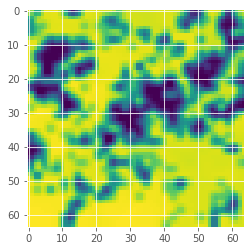

In [99]:
plt.imshow(x_train[0,0,:,:])


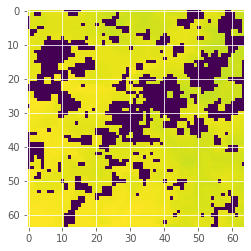

In [100]:
plt.imshow(y_train[0,0,:,:])

In [101]:
# the dataset module
class SRCNNDataset(Dataset):
    def __init__(self, image_data, labels):
        self.image_data = image_data
        self.labels = labels
    def __len__(self):
        return (len(self.image_data))
    def __getitem__(self, index):
        image = self.image_data[index]
        label = self.labels[index]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

In [102]:
# train and validation data
train_data = SRCNNDataset(x_train, y_train)
val_data = SRCNNDataset(x_val, y_val)
# train and validation loaders
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [103]:
# initialize the model
print('Computation device: ', device)
model = SRCNN().to(device)
print(model)

Computation device:  cuda
SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
)


In [104]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function 
criterion = nn.MSELoss()

In [105]:
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(np.max(label) / rmse)
        return PSNR

In [106]:
def ssim(label, outputs):

    label = label.cpu().detach().numpy().reshape(label.shape[0], label.shape[2], label.shape[3])
    outputs = outputs.cpu().detach().numpy().reshape(outputs.shape[0], outputs.shape[2], outputs.shape[3])

    ssim_maps = []
    for labe, out in zip(label, outputs):
      C1 = (0.01 * np.max(labe))**2
      C2 = (0.03 * np.max(labe))**2

      img1 = labe.astype(np.float64)
      img2 = out.astype(np.float64)
      kernel = cv2.getGaussianKernel(11, 1.5)
      window = np.outer(kernel, kernel.transpose())

      mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
      mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
      mu1_sq = mu1**2
      mu2_sq = mu2**2
      mu1_mu2 = mu1 * mu2
      sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
      sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
      sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

      ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
      ssim_maps.append(ssim_map)
    return np.array(ssim_map).mean()

In [107]:
def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0
    for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # zero grad the optimizer
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, label)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        # add loss of each item (total items in a batch = batch size)
        running_loss += loss.item()
        # calculate batch psnr (once every `batch_size` iterations)
        batch_psnr =  psnr(label, outputs)
        running_psnr += batch_psnr
        batch_ssim =  ssim(label, outputs)
        running_ssim += batch_ssim
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(train_data)/dataloader.batch_size)
    final_ssim = running_ssim/int(len(train_data)/dataloader.batch_size)
    return final_loss, final_psnr, final_ssim

In [108]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(outputs, label)
            # add loss of each item (total items in a batch = batch size) 
            running_loss += loss.item()
            # calculate batch psnr (once every `batch_size` iterations)
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr
            batch_ssim =  ssim(label, outputs)
            running_ssim += batch_ssim
        outputs = outputs.cpu()
        # save_image(outputs, f"../outputs/val_sr{epoch}.png")
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(val_data)/dataloader.batch_size)
    final_ssim = running_ssim/int(len(val_data)/dataloader.batch_size)
    return final_loss, final_psnr, final_ssim

In [109]:
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
train_ssim, val_ssim = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr, train_epoch_ssim = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr, val_epoch_ssim = validate(model, val_loader, epoch)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    print(f"Train SSIM: {train_epoch_ssim:.3f}")
    print(f"Val SSIM: {val_epoch_ssim:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    train_ssim.append(train_epoch_ssim)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
    val_ssim.append(val_epoch_ssim)
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

Epoch 1 of 100


58it [00:00, 59.49it/s]                        
25it [00:00, 70.14it/s]                        


Train PSNR: 13.026
Val PSNR: 16.027
Train SSIM: 0.623
Val SSIM: 0.687
Epoch 2 of 100


58it [00:00, 61.00it/s]                        
25it [00:00, 65.24it/s]                        


Train PSNR: 16.268
Val PSNR: 17.127
Train SSIM: 0.754
Val SSIM: 0.759
Epoch 3 of 100


58it [00:00, 60.30it/s]                        
25it [00:00, 68.22it/s]                        


Train PSNR: 16.942
Val PSNR: 17.595
Train SSIM: 0.783
Val SSIM: 0.778
Epoch 4 of 100


58it [00:00, 58.77it/s]                        
25it [00:00, 65.87it/s]                        


Train PSNR: 17.283
Val PSNR: 17.857
Train SSIM: 0.800
Val SSIM: 0.801
Epoch 5 of 100


58it [00:00, 60.17it/s]                        
25it [00:00, 62.68it/s]                        


Train PSNR: 17.494
Val PSNR: 18.000
Train SSIM: 0.816
Val SSIM: 0.816
Epoch 6 of 100


58it [00:00, 59.78it/s]                        
25it [00:00, 68.05it/s]                        


Train PSNR: 17.656
Val PSNR: 18.155
Train SSIM: 0.828
Val SSIM: 0.828
Epoch 7 of 100


58it [00:00, 60.51it/s]                        
25it [00:00, 68.09it/s]                        


Train PSNR: 17.742
Val PSNR: 18.196
Train SSIM: 0.837
Val SSIM: 0.834
Epoch 8 of 100


58it [00:00, 61.12it/s]                        
25it [00:00, 70.30it/s]                        


Train PSNR: 17.811
Val PSNR: 18.289
Train SSIM: 0.840
Val SSIM: 0.838
Epoch 9 of 100


58it [00:00, 61.66it/s]                        
25it [00:00, 70.85it/s]                        


Train PSNR: 17.888
Val PSNR: 18.361
Train SSIM: 0.844
Val SSIM: 0.842
Epoch 10 of 100


58it [00:00, 63.30it/s]                        
25it [00:00, 67.32it/s]                        


Train PSNR: 17.949
Val PSNR: 18.432
Train SSIM: 0.846
Val SSIM: 0.846
Epoch 11 of 100


58it [00:00, 60.98it/s]                        
25it [00:00, 72.83it/s]                        


Train PSNR: 18.036
Val PSNR: 18.511
Train SSIM: 0.850
Val SSIM: 0.850
Epoch 12 of 100


58it [00:00, 61.52it/s]                        
25it [00:00, 69.89it/s]                        


Train PSNR: 18.110
Val PSNR: 18.584
Train SSIM: 0.854
Val SSIM: 0.854
Epoch 13 of 100


58it [00:00, 60.08it/s]                        
25it [00:00, 69.29it/s]                        


Train PSNR: 18.176
Val PSNR: 18.642
Train SSIM: 0.857
Val SSIM: 0.858
Epoch 14 of 100


58it [00:00, 61.44it/s]                        
25it [00:00, 72.10it/s]                        


Train PSNR: 18.233
Val PSNR: 18.699
Train SSIM: 0.860
Val SSIM: 0.862
Epoch 15 of 100


58it [00:00, 61.04it/s]                        
25it [00:00, 60.96it/s]                        


Train PSNR: 18.259
Val PSNR: 18.688
Train SSIM: 0.862
Val SSIM: 0.863
Epoch 16 of 100


58it [00:00, 61.32it/s]                        
25it [00:00, 65.70it/s]                        


Train PSNR: 18.353
Val PSNR: 18.798
Train SSIM: 0.865
Val SSIM: 0.867
Epoch 17 of 100


58it [00:00, 58.73it/s]                        
25it [00:00, 69.28it/s]                        


Train PSNR: 18.398
Val PSNR: 18.844
Train SSIM: 0.867
Val SSIM: 0.870
Epoch 18 of 100


58it [00:00, 59.01it/s]                        
25it [00:00, 66.76it/s]                        


Train PSNR: 18.439
Val PSNR: 18.891
Train SSIM: 0.868
Val SSIM: 0.872
Epoch 19 of 100


58it [00:01, 57.94it/s]                        
25it [00:00, 68.11it/s]                        


Train PSNR: 18.445
Val PSNR: 18.923
Train SSIM: 0.869
Val SSIM: 0.871
Epoch 20 of 100


58it [00:00, 61.31it/s]                        
25it [00:00, 65.28it/s]                        


Train PSNR: 18.524
Val PSNR: 18.964
Train SSIM: 0.872
Val SSIM: 0.875
Epoch 21 of 100


58it [00:00, 60.04it/s]                        
25it [00:00, 66.44it/s]                        


Train PSNR: 18.561
Val PSNR: 18.997
Train SSIM: 0.873
Val SSIM: 0.877
Epoch 22 of 100


58it [00:00, 58.69it/s]                        
25it [00:00, 65.62it/s]                        


Train PSNR: 18.581
Val PSNR: 19.028
Train SSIM: 0.874
Val SSIM: 0.878
Epoch 23 of 100


58it [00:00, 59.86it/s]                        
25it [00:00, 64.65it/s]                        


Train PSNR: 18.616
Val PSNR: 19.053
Train SSIM: 0.875
Val SSIM: 0.880
Epoch 24 of 100


58it [00:01, 57.69it/s]                        
25it [00:00, 67.52it/s]                        


Train PSNR: 18.638
Val PSNR: 19.079
Train SSIM: 0.876
Val SSIM: 0.881
Epoch 25 of 100


58it [00:00, 61.55it/s]                        
25it [00:00, 68.03it/s]                        


Train PSNR: 18.676
Val PSNR: 19.114
Train SSIM: 0.878
Val SSIM: 0.881
Epoch 26 of 100


58it [00:00, 61.50it/s]                        
25it [00:00, 64.57it/s]                        


Train PSNR: 18.698
Val PSNR: 19.134
Train SSIM: 0.878
Val SSIM: 0.882
Epoch 27 of 100


58it [00:00, 61.55it/s]                        
25it [00:00, 67.41it/s]                        


Train PSNR: 18.698
Val PSNR: 19.149
Train SSIM: 0.879
Val SSIM: 0.883
Epoch 28 of 100


58it [00:00, 60.79it/s]                        
25it [00:00, 70.21it/s]                        


Train PSNR: 18.758
Val PSNR: 19.174
Train SSIM: 0.881
Val SSIM: 0.886
Epoch 29 of 100


58it [00:00, 60.17it/s]                        
25it [00:00, 69.70it/s]                        


Train PSNR: 18.689
Val PSNR: 19.127
Train SSIM: 0.880
Val SSIM: 0.883
Epoch 30 of 100


58it [00:00, 60.17it/s]                        
25it [00:00, 67.29it/s]                        


Train PSNR: 18.761
Val PSNR: 19.155
Train SSIM: 0.883
Val SSIM: 0.884
Epoch 31 of 100


58it [00:00, 60.07it/s]                        
25it [00:00, 66.84it/s]                        


Train PSNR: 18.784
Val PSNR: 19.217
Train SSIM: 0.883
Val SSIM: 0.887
Epoch 32 of 100


58it [00:00, 60.70it/s]                        
25it [00:00, 67.58it/s]                        


Train PSNR: 18.818
Val PSNR: 19.226
Train SSIM: 0.884
Val SSIM: 0.887
Epoch 33 of 100


58it [00:00, 61.52it/s]                        
25it [00:00, 69.43it/s]                        


Train PSNR: 18.836
Val PSNR: 19.261
Train SSIM: 0.884
Val SSIM: 0.889
Epoch 34 of 100


58it [00:00, 61.96it/s]                        
25it [00:00, 69.25it/s]                        


Train PSNR: 18.859
Val PSNR: 19.263
Train SSIM: 0.885
Val SSIM: 0.890
Epoch 35 of 100


58it [00:00, 62.60it/s]                        
25it [00:00, 69.28it/s]                        


Train PSNR: 18.867
Val PSNR: 19.290
Train SSIM: 0.885
Val SSIM: 0.890
Epoch 36 of 100


58it [00:00, 63.16it/s]                        
25it [00:00, 71.37it/s]                        


Train PSNR: 18.874
Val PSNR: 19.299
Train SSIM: 0.885
Val SSIM: 0.890
Epoch 37 of 100


58it [00:00, 61.76it/s]                        
25it [00:00, 72.22it/s]                        


Train PSNR: 18.887
Val PSNR: 19.313
Train SSIM: 0.886
Val SSIM: 0.892
Epoch 38 of 100


58it [00:00, 60.70it/s]                        
25it [00:00, 69.38it/s]                        


Train PSNR: 18.887
Val PSNR: 19.323
Train SSIM: 0.886
Val SSIM: 0.892
Epoch 39 of 100


58it [00:00, 61.46it/s]                        
25it [00:00, 68.04it/s]                        


Train PSNR: 18.903
Val PSNR: 19.330
Train SSIM: 0.887
Val SSIM: 0.893
Epoch 40 of 100


58it [00:00, 64.23it/s]                        
25it [00:00, 71.05it/s]                        


Train PSNR: 18.902
Val PSNR: 19.344
Train SSIM: 0.887
Val SSIM: 0.893
Epoch 41 of 100


58it [00:00, 63.33it/s]                        
25it [00:00, 70.03it/s]                        


Train PSNR: 18.694
Val PSNR: 19.228
Train SSIM: 0.883
Val SSIM: 0.881
Epoch 42 of 100


58it [00:00, 61.86it/s]                        
25it [00:00, 73.47it/s]                        


Train PSNR: 18.924
Val PSNR: 19.347
Train SSIM: 0.885
Val SSIM: 0.893
Epoch 43 of 100


58it [00:00, 59.60it/s]                        
25it [00:00, 68.77it/s]                        


Train PSNR: 18.949
Val PSNR: 19.343
Train SSIM: 0.887
Val SSIM: 0.892
Epoch 44 of 100


58it [00:00, 61.25it/s]                        
25it [00:00, 68.62it/s]                        


Train PSNR: 18.970
Val PSNR: 19.364
Train SSIM: 0.888
Val SSIM: 0.893
Epoch 45 of 100


58it [00:00, 62.33it/s]                        
25it [00:00, 72.05it/s]                        


Train PSNR: 18.977
Val PSNR: 19.348
Train SSIM: 0.888
Val SSIM: 0.894
Epoch 46 of 100


58it [00:00, 60.53it/s]                        
25it [00:00, 69.97it/s]                        


Train PSNR: 18.984
Val PSNR: 19.361
Train SSIM: 0.889
Val SSIM: 0.894
Epoch 47 of 100


58it [00:00, 61.09it/s]                        
25it [00:00, 69.18it/s]                        


Train PSNR: 18.983
Val PSNR: 19.388
Train SSIM: 0.889
Val SSIM: 0.896
Epoch 48 of 100


58it [00:00, 60.89it/s]                        
25it [00:00, 70.47it/s]                        


Train PSNR: 18.973
Val PSNR: 19.394
Train SSIM: 0.889
Val SSIM: 0.896
Epoch 49 of 100


58it [00:00, 60.86it/s]                        
25it [00:00, 72.51it/s]                        


Train PSNR: 19.004
Val PSNR: 19.403
Train SSIM: 0.890
Val SSIM: 0.897
Epoch 50 of 100


58it [00:00, 62.18it/s]                        
25it [00:00, 65.87it/s]                        


Train PSNR: 18.989
Val PSNR: 19.418
Train SSIM: 0.889
Val SSIM: 0.896
Epoch 51 of 100


58it [00:00, 60.95it/s]                        
25it [00:00, 69.87it/s]                        


Train PSNR: 19.009
Val PSNR: 19.421
Train SSIM: 0.890
Val SSIM: 0.897
Epoch 52 of 100


58it [00:00, 61.19it/s]                        
25it [00:00, 66.66it/s]                        


Train PSNR: 19.013
Val PSNR: 19.430
Train SSIM: 0.890
Val SSIM: 0.897
Epoch 53 of 100


58it [00:00, 61.06it/s]                        
25it [00:00, 72.90it/s]                        


Train PSNR: 18.987
Val PSNR: 19.378
Train SSIM: 0.890
Val SSIM: 0.896
Epoch 54 of 100


58it [00:00, 60.78it/s]                        
25it [00:00, 69.59it/s]                        


Train PSNR: 19.032
Val PSNR: 19.438
Train SSIM: 0.890
Val SSIM: 0.898
Epoch 55 of 100


58it [00:00, 62.29it/s]                        
25it [00:00, 69.00it/s]                        


Train PSNR: 18.856
Val PSNR: 19.089
Train SSIM: 0.888
Val SSIM: 0.888
Epoch 56 of 100


58it [00:00, 60.43it/s]                        
25it [00:00, 71.39it/s]                        


Train PSNR: 19.008
Val PSNR: 19.426
Train SSIM: 0.888
Val SSIM: 0.896
Epoch 57 of 100


58it [00:00, 59.00it/s]                        
25it [00:00, 68.06it/s]                        


Train PSNR: 19.060
Val PSNR: 19.429
Train SSIM: 0.891
Val SSIM: 0.896
Epoch 58 of 100


58it [00:00, 59.42it/s]                        
25it [00:00, 69.56it/s]                        


Train PSNR: 19.051
Val PSNR: 19.436
Train SSIM: 0.891
Val SSIM: 0.894
Epoch 59 of 100


58it [00:00, 59.90it/s]                        
25it [00:00, 68.37it/s]                        


Train PSNR: 19.062
Val PSNR: 19.425
Train SSIM: 0.892
Val SSIM: 0.896
Epoch 60 of 100


58it [00:00, 59.45it/s]
25it [00:00, 66.80it/s]                        


Train PSNR: 19.055
Val PSNR: 19.459
Train SSIM: 0.891
Val SSIM: 0.896
Epoch 61 of 100


58it [00:00, 60.79it/s]                        
25it [00:00, 69.01it/s]                        


Train PSNR: 19.069
Val PSNR: 19.468
Train SSIM: 0.892
Val SSIM: 0.897
Epoch 62 of 100


58it [00:00, 60.83it/s]                        
25it [00:00, 71.36it/s]                        


Train PSNR: 19.080
Val PSNR: 19.463
Train SSIM: 0.891
Val SSIM: 0.898
Epoch 63 of 100


58it [00:00, 61.36it/s]                        
25it [00:00, 67.11it/s]                        


Train PSNR: 18.806
Val PSNR: 19.386
Train SSIM: 0.884
Val SSIM: 0.891
Epoch 64 of 100


58it [00:01, 57.21it/s]                        
25it [00:00, 63.42it/s]                        


Train PSNR: 19.062
Val PSNR: 19.453
Train SSIM: 0.889
Val SSIM: 0.896
Epoch 65 of 100


58it [00:00, 61.08it/s]                        
25it [00:00, 67.07it/s]                        


Train PSNR: 19.086
Val PSNR: 19.476
Train SSIM: 0.891
Val SSIM: 0.895
Epoch 66 of 100


58it [00:00, 62.84it/s]                        
25it [00:00, 68.71it/s]                        


Train PSNR: 19.078
Val PSNR: 19.457
Train SSIM: 0.891
Val SSIM: 0.894
Epoch 67 of 100


58it [00:00, 62.46it/s]                        
25it [00:00, 65.95it/s]                        


Train PSNR: 19.087
Val PSNR: 19.448
Train SSIM: 0.891
Val SSIM: 0.896
Epoch 68 of 100


58it [00:00, 58.82it/s]
25it [00:00, 68.55it/s]                        


Train PSNR: 19.092
Val PSNR: 19.473
Train SSIM: 0.891
Val SSIM: 0.894
Epoch 69 of 100


58it [00:00, 60.71it/s]                        
25it [00:00, 71.06it/s]                        


Train PSNR: 19.105
Val PSNR: 19.484
Train SSIM: 0.892
Val SSIM: 0.896
Epoch 70 of 100


58it [00:00, 60.64it/s]                        
25it [00:00, 68.94it/s]                        


Train PSNR: 19.103
Val PSNR: 19.500
Train SSIM: 0.892
Val SSIM: 0.897
Epoch 71 of 100


58it [00:00, 60.21it/s]                        
25it [00:00, 69.46it/s]                        


Train PSNR: 19.112
Val PSNR: 19.474
Train SSIM: 0.893
Val SSIM: 0.898
Epoch 72 of 100


58it [00:00, 59.32it/s]                        
25it [00:00, 72.70it/s]                        


Train PSNR: 19.129
Val PSNR: 19.483
Train SSIM: 0.893
Val SSIM: 0.895
Epoch 73 of 100


58it [00:00, 61.10it/s]                        
25it [00:00, 69.60it/s]                        


Train PSNR: 19.123
Val PSNR: 19.487
Train SSIM: 0.893
Val SSIM: 0.891
Epoch 74 of 100


58it [00:00, 61.11it/s]                        
25it [00:00, 71.15it/s]                        


Train PSNR: 19.089
Val PSNR: 19.542
Train SSIM: 0.892
Val SSIM: 0.898
Epoch 75 of 100


58it [00:00, 62.65it/s]                        
25it [00:00, 64.32it/s]                        


Train PSNR: 19.112
Val PSNR: 19.489
Train SSIM: 0.893
Val SSIM: 0.898
Epoch 76 of 100


58it [00:00, 60.24it/s]                        
25it [00:00, 65.24it/s]                        


Train PSNR: 19.143
Val PSNR: 19.526
Train SSIM: 0.892
Val SSIM: 0.896
Epoch 77 of 100


58it [00:00, 60.72it/s]                        
25it [00:00, 72.47it/s]                        


Train PSNR: 19.060
Val PSNR: 19.547
Train SSIM: 0.892
Val SSIM: 0.895
Epoch 78 of 100


58it [00:00, 59.19it/s]                        
25it [00:00, 63.21it/s]                        


Train PSNR: 19.140
Val PSNR: 19.557
Train SSIM: 0.892
Val SSIM: 0.898
Epoch 79 of 100


58it [00:00, 59.41it/s]                        
25it [00:00, 69.56it/s]                        


Train PSNR: 19.159
Val PSNR: 19.575
Train SSIM: 0.892
Val SSIM: 0.898
Epoch 80 of 100


58it [00:00, 61.05it/s]                        
25it [00:00, 65.79it/s]                        


Train PSNR: 19.144
Val PSNR: 19.577
Train SSIM: 0.892
Val SSIM: 0.897
Epoch 81 of 100


58it [00:00, 61.60it/s]                        
25it [00:00, 70.85it/s]                        


Train PSNR: 19.184
Val PSNR: 19.596
Train SSIM: 0.892
Val SSIM: 0.900
Epoch 82 of 100


58it [00:00, 61.93it/s]                        
25it [00:00, 66.07it/s]                        


Train PSNR: 19.182
Val PSNR: 19.566
Train SSIM: 0.892
Val SSIM: 0.900
Epoch 83 of 100


58it [00:00, 60.75it/s]                        
25it [00:00, 72.89it/s]                        


Train PSNR: 19.120
Val PSNR: 19.582
Train SSIM: 0.890
Val SSIM: 0.896
Epoch 84 of 100


58it [00:00, 62.59it/s]                        
25it [00:00, 70.42it/s]                        


Train PSNR: 19.115
Val PSNR: 19.582
Train SSIM: 0.890
Val SSIM: 0.898
Epoch 85 of 100


58it [00:00, 62.41it/s]                        
25it [00:00, 70.74it/s]                        


Train PSNR: 19.213
Val PSNR: 19.509
Train SSIM: 0.892
Val SSIM: 0.898
Epoch 86 of 100


58it [00:00, 60.92it/s]                        
25it [00:00, 67.92it/s]                        


Train PSNR: 19.103
Val PSNR: 19.549
Train SSIM: 0.890
Val SSIM: 0.894
Epoch 87 of 100


58it [00:00, 62.77it/s]                        
25it [00:00, 68.68it/s]                        


Train PSNR: 19.218
Val PSNR: 19.524
Train SSIM: 0.892
Val SSIM: 0.898
Epoch 88 of 100


58it [00:00, 61.76it/s]                        
25it [00:00, 70.44it/s]                        


Train PSNR: 19.167
Val PSNR: 19.588
Train SSIM: 0.892
Val SSIM: 0.902
Epoch 89 of 100


58it [00:00, 61.28it/s]                        
25it [00:00, 65.87it/s]                        


Train PSNR: 19.216
Val PSNR: 19.579
Train SSIM: 0.893
Val SSIM: 0.904
Epoch 90 of 100


58it [00:00, 61.56it/s]                        
25it [00:00, 67.64it/s]                        


Train PSNR: 19.197
Val PSNR: 19.602
Train SSIM: 0.892
Val SSIM: 0.901
Epoch 91 of 100


58it [00:00, 62.21it/s]                        
25it [00:00, 71.00it/s]                        


Train PSNR: 19.233
Val PSNR: 19.568
Train SSIM: 0.893
Val SSIM: 0.902
Epoch 92 of 100


58it [00:00, 62.62it/s]                        
25it [00:00, 64.24it/s]                        


Train PSNR: 19.194
Val PSNR: 19.636
Train SSIM: 0.891
Val SSIM: 0.903
Epoch 93 of 100


58it [00:01, 57.78it/s]                        
25it [00:00, 65.86it/s]                        


Train PSNR: 19.244
Val PSNR: 19.596
Train SSIM: 0.893
Val SSIM: 0.901
Epoch 94 of 100


58it [00:00, 59.16it/s]                        
25it [00:00, 63.17it/s]                        


Train PSNR: 19.210
Val PSNR: 19.655
Train SSIM: 0.892
Val SSIM: 0.902
Epoch 95 of 100


58it [00:00, 61.58it/s]                        
25it [00:00, 64.90it/s]                        


Train PSNR: 19.249
Val PSNR: 19.597
Train SSIM: 0.893
Val SSIM: 0.903
Epoch 96 of 100


58it [00:00, 59.82it/s]                        
25it [00:00, 68.17it/s]                        


Train PSNR: 19.197
Val PSNR: 19.643
Train SSIM: 0.892
Val SSIM: 0.896
Epoch 97 of 100


58it [00:00, 62.19it/s]                        
25it [00:00, 68.59it/s]                        


Train PSNR: 19.294
Val PSNR: 19.582
Train SSIM: 0.894
Val SSIM: 0.901
Epoch 98 of 100


58it [00:00, 61.30it/s]                        
25it [00:00, 66.63it/s]                        


Train PSNR: 19.191
Val PSNR: 19.640
Train SSIM: 0.889
Val SSIM: 0.895
Epoch 99 of 100


58it [00:00, 61.18it/s]                        
25it [00:00, 69.16it/s]                        


Train PSNR: 19.303
Val PSNR: 19.621
Train SSIM: 0.894
Val SSIM: 0.902
Epoch 100 of 100


58it [00:00, 62.94it/s]                        
25it [00:00, 72.17it/s]                        

Train PSNR: 19.211
Val PSNR: 19.628
Train SSIM: 0.891
Val SSIM: 0.901
Finished training in: 2.222 minutes


In [110]:
torch.save(model.state_dict(), 'model64_2.pth')

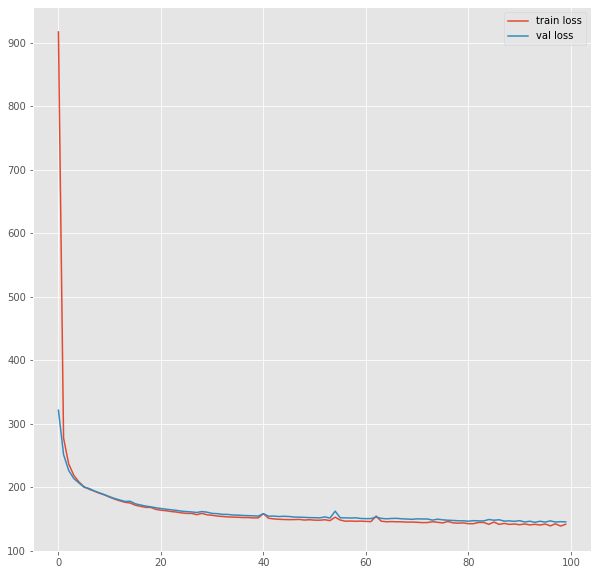

In [111]:
plt.figure(figsize=(10,10))
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["train loss", "val loss"])

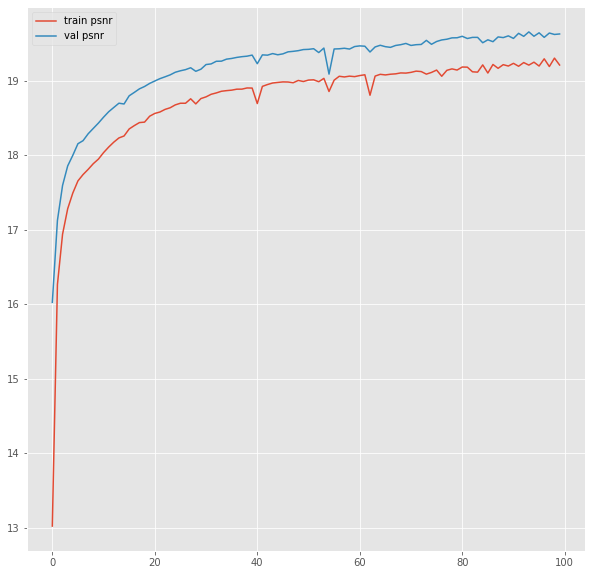

In [112]:
plt.figure(figsize=(10,10))
plt.plot(train_psnr)
plt.plot(val_psnr)
plt.legend(["train psnr", "val psnr"])

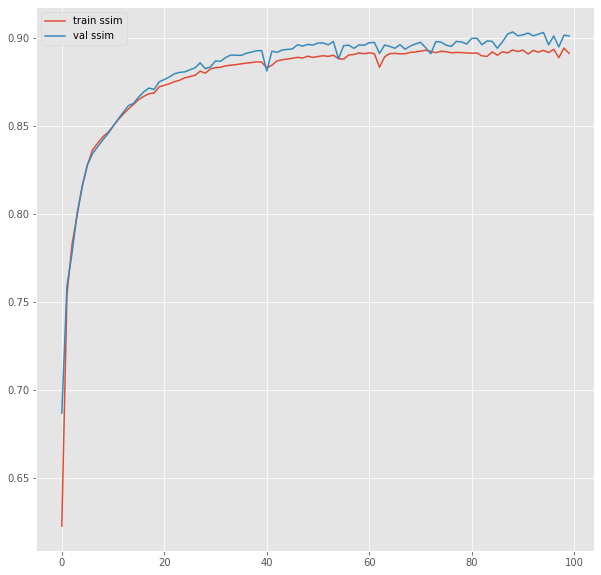

In [113]:
plt.figure(figsize=(10,10))
plt.plot(train_ssim)
plt.plot(val_ssim)
plt.legend(["train ssim", "val ssim"])

In [114]:
def psnr_notorch(label, outputs):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    # label = label.cpu().detach().numpy()
    # outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(np.max(label) / rmse)
        return PSNR, rmse

In [118]:
PSNR_bicubic, rmse = psnr_notorch(y_val[50,0,:,:], x_val[50,0,:,:])
print(PSNR_bicubic, rmse)

16.684010505169088 41.19511129700882


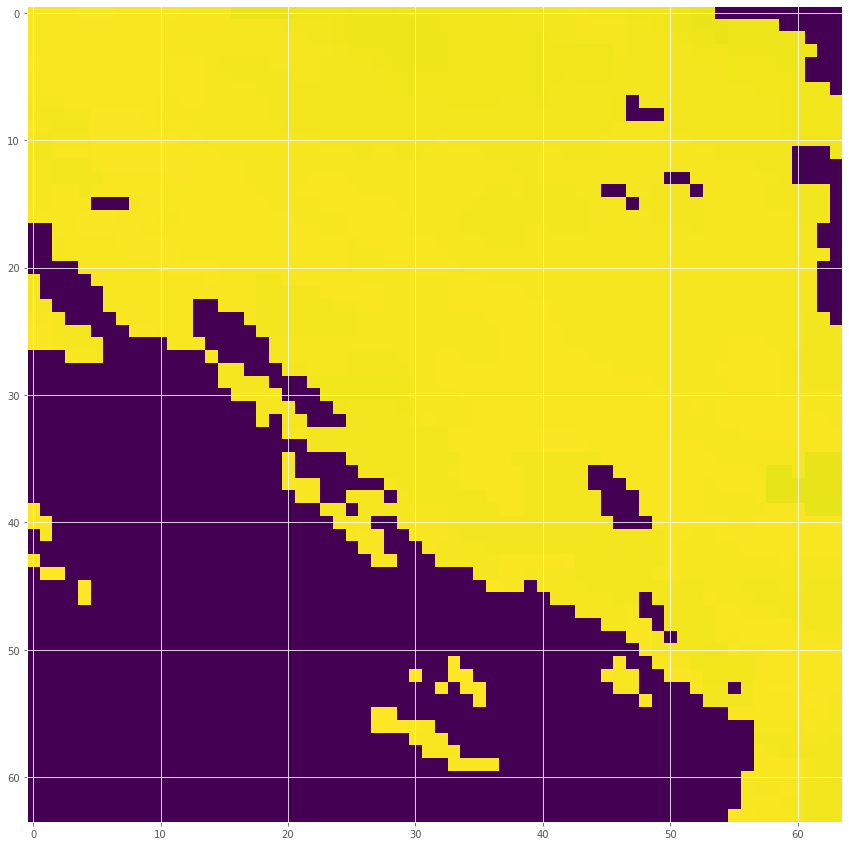

In [124]:
plt.figure(figsize=(15,15))
plt.imshow(y_val[50,0,:,:])

In [119]:
input = torch.tensor(np.reshape(x_val[50,0,:,:], (1,1,64,64)), dtype=torch.float)
input = input.to(device)

In [120]:
output = model(input).cpu().detach().numpy()

In [121]:
PSNR_bicubic, rmse = psnr_notorch(y_val[50,0,:,:], output[0,0,:,:])
print(PSNR_bicubic, rmse)

18.268746917682364 34.324866744861254


In [ ]:
np.max(y_train[1084,0,:,:]), np.max(output)

(282.86, 343.3493)

Text(0.5, 1.0, 'GT')

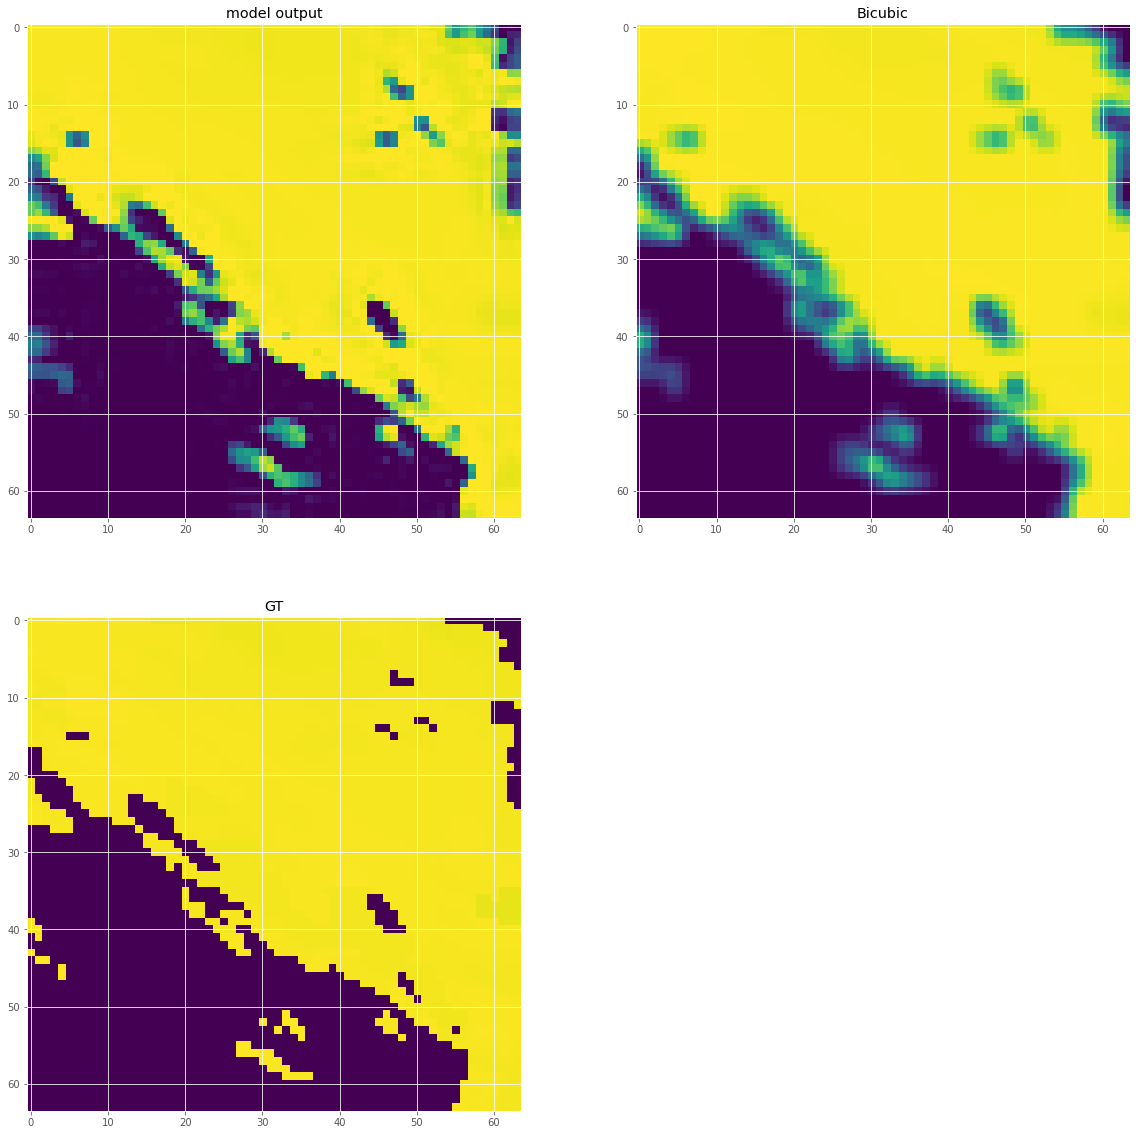

In [126]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(output[0,0,:,:], vmin = 0, vmax = np.max(x_val[50,:,:]))
plt.title("model output")
plt.subplot(2,2,2)
plt.imshow(x_val[50,0,:,:])
plt.title("Bicubic")
plt.subplot(2,2,3)
plt.imshow(y_val[50,0,:,:])
plt.title("GT")